# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

## Answer:
Setting car price as our target what features have the most influence on our target price?  We can first use exploratory data analysis (EDA) to get a better understanding of our features and how their variance effects the target value.  We can then build models and use cross validation to find what the hyper parameters are to enable us to predict what model, features and hyper parameters to use to best predict price.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

## Answer:
Some of the steps we should take to get familiar with our data are:

-Basic understanding of the features and what the columns in our dataframe represent

-Check the variance of our target and numerical features to help us understand if we need to normalize or remove any outliers

-Look at the feature datatypes to understand if we have ordinal or categorical values, how their variance affects the target and decide if we convert to numerical features

-Understand if there are any correlations between the numerical features


In [40]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor, make_column_transformer
from sklearn import set_config
from sklearn.inspection import permutation_importance
from scipy import stats
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
set_config(display="diagram")


import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
import warnings
import statsmodels.api as sm

In [3]:
cars = pd.read_csv('data/vehicles.csv')

In [4]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [5]:
# Count total NaN on each column in a DataFrame, we have a lot missing and can drop a few:
print(f" \nMissing or Null Value Count: \n\n{cars.isna().sum()}\n\nPercent Missing: \n{cars.isna().sum() * 100 / len(cars)}\n")

 
Missing or Null Value Count: 

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

Percent Missing: 
id               0.000000
region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64



In [6]:
#let's drop columns missing more than say 30% of data as we can't impute them properly, id is also not needed:
cars_cleaning = cars.drop(['id', 'condition', 'cylinders', 'VIN', 'drive', 'size', 'paint_color', 'type'], axis = 1)

In [8]:
#let's look at categorical values and how many of each:
print(f"Unique Values for categorical columns:")
for col in cars_cleaning.select_dtypes(include='object'):
  print(f"  {cars[col].nunique()} unique values - {col}: {cars[col].unique()}\n")

Unique Values for categorical columns:
  404 unique values - region: ['prescott' 'fayetteville' 'florida keys' 'worcester / central MA'
 'greensboro' 'hudson valley' 'medford-ashland' 'erie' 'el paso'
 'bellingham' 'skagit / island / SJI' 'la crosse' 'auburn' 'birmingham'
 'dothan' 'florence / muscle shoals' 'gadsden-anniston'
 'huntsville / decatur' 'mobile' 'montgomery' 'tuscaloosa'
 'anchorage / mat-su' 'fairbanks' 'kenai peninsula' 'southeast alaska'
 'flagstaff / sedona' 'mohave county' 'phoenix' 'show low' 'sierra vista'
 'tucson' 'yuma' 'fort smith' 'jonesboro' 'little rock' 'texarkana'
 'bakersfield' 'chico' 'fresno / madera' 'gold country' 'hanford-corcoran'
 'humboldt county' 'imperial county' 'inland empire' 'los angeles'
 'mendocino county' 'merced' 'modesto' 'monterey bay' 'orange county'
 'palm springs' 'redding' 'reno / tahoe' 'sacramento' 'san diego'
 'san luis obispo' 'santa barbara' 'santa maria' 'SF bay area'
 'siskiyou county' 'stockton' 'susanville' 'ventura county

In [10]:
#let's split our features into numerical and categorical to analize further:
cars_numericals = cars_cleaning.select_dtypes(['int64','float64'])
cars_categoricals = cars_cleaning.select_dtypes(['object','bool'])

# these are lists
numericals = [i for i in cars_numericals.columns]
categoricals = [i for i in cars_categoricals.columns]

print('numericals: ', numericals)
print('categoricals: ', categoricals)

numericals:  ['price', 'year', 'odometer']
categoricals:  ['region', 'manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'state']


In [11]:
# Let's fill out missing data in the remaining columns (we did not drop earlier) with imputation:
# For numerical columns (mean):
for col in numericals:
    cars_cleaning[col].fillna(cars_cleaning[col].mean(), inplace=True)

# For categorical columns (mode):
for col in categoricals:
    cars_cleaning[col].fillna(cars_cleaning[col].mode()[0], inplace=True)

In [12]:
#after imputing we probably have a lot of new duplicates
duplicates = len(cars_cleaning)-len(cars_cleaning.drop_duplicates())
print(duplicates)

57336


In [13]:
#remove duplicates and reset index:
cars_cleaning = cars_cleaning.drop_duplicates()
cars_cleaning = cars_cleaning.reset_index(drop=True)

/Users/stephenthorpe/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/stephenthorpe/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


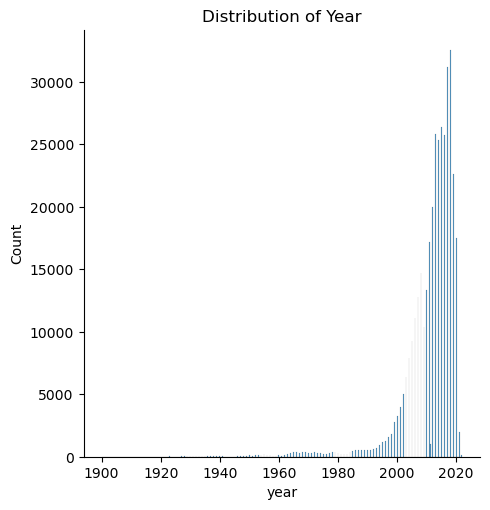

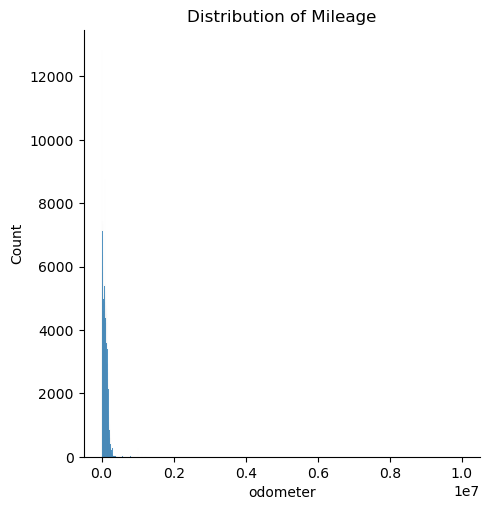

In [14]:
# Plot distribution of numerical variables (except our target), we have significant outliers to remove:
sns.displot(cars_cleaning['year']).set(title='Distribution of Year')
sns.displot(cars_cleaning['odometer']).set(title='Distribution of Mileage')

[Text(0.5, 1.0, 'Vehicles vs Sales by Price')]

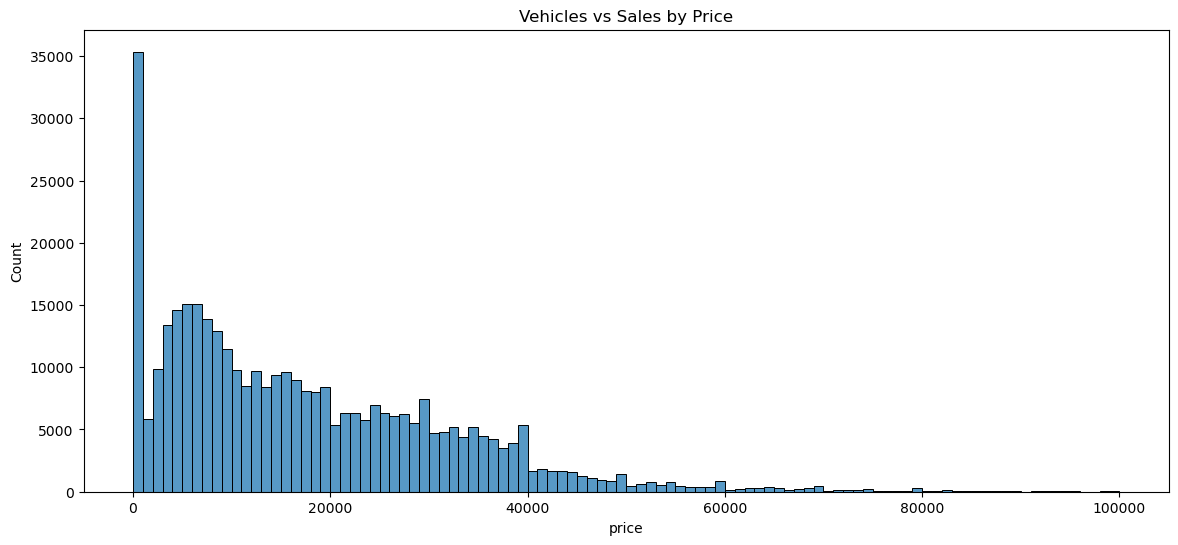

In [15]:
#let's look at the distribution of our target data price, we also have outliers and lot's of 0's so filtering:
x_data =cars_cleaning.query('price < 100000')['price']
fig, ax = plt.subplots (figsize=(14, 6))
sns.histplot(x_data, bins=100).set(title='Vehicles vs Sales by Price')

In [ ]:
# Plot the categorical variables, both on their own (on the left) and against price (on the right):

fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(28,40))

sns.countplot(data=cars_cleaning, x='fuel', ax=axs[0][0])
sns.boxplot(data=cars_cleaning, x='fuel', y='price', ax=axs[0][1])

sns.countplot(data=cars_cleaning, x='title_status', ax=axs[1][0])
sns.boxplot(data=cars_cleaning, x='title_status', y='price', ax=axs[1][1])

sns.countplot(data=cars_cleaning, x='transmission', ax=axs[2][0])
sns.boxplot(data=cars_cleaning, x='transmission', y='price', ax=axs[2][1])

sns.countplot(data=cars_cleaning, x='type', ax=axs[3][0])
sns.boxplot(data=cars_cleaning, x='type', y='price', ax=axs[3][1])

sns.countplot(data=cars_cleaning, x='age', ax=axs[4][0])
sns.boxplot(data=cars_cleaning, x='age', y='price', ax=axs[4][1])

sns.countplot(data=cars_cleaning, x='state', ax=axs[5][0])
sns.boxplot(data=cars_cleaning, x='state', y='price', ax=axs[5][1])

In [16]:
#remove outliers, got help on running this on Kaggle
#THE FEATURES WE ARE CONSIDERING FOR OUTLIER REMOVAL 
list_of_input_features_for_outliers = ['price', 'odometer', 'year']
#we can see we have quite a number of outliers to handle them we can use Z scoring
#calculating Zscore = (data_point — mean) / std. deviation
# IMPORTING LIBRARY NEEDED FOR Z-SCORE CALCULATION AND DEFINING THRESHOLD VALUE 
#3 is 3 standard deviations and should account for 99% of data
threshold = 3

# DEFINING THE FUNCTION TO CALULATE THE Z-SCORE VLAUE 
# Position of the outlier # where (z > threshold) 
def calc_z_score_mask(feature_name): 
  z_score = np.abs(stats.zscore(cars_cleaning[feature_name])) 
  return z_score > threshold 

#CREATING A MASK - MARKING ALL THE ELEMENTS THAT ARE CONSIDERED OUTLIERS i.e. OUT OF LIMITS 
#LIST CORRESPONDING TO EACH FEATURE 
list_of_masks_for_outlier_removal_z = [] 
for feature in list_of_input_features_for_outliers: 
    feature_mask = calc_z_score_mask(feature) 
    list_of_masks_for_outlier_removal_z.append(feature_mask) 

#CREATING A MASK FOR OVERALL DATA RECORDS WITH RESPECT TO ALL THE FEATURES
mask_for_outlier_removal_z = np.any(list_of_masks_for_outlier_removal_z, axis = 0) 

# OUTLIER POSITIONS 
list_of_records_with_outliers_z = np.where(mask_for_outlier_removal_z) 

#NUMBER OF TOTAL OUTLIERS 

len(list_of_records_with_outliers_z[0])

9264

In [17]:
# Update Dataset with Outliers with Z score removed
cars_cleaning = cars_cleaning.drop(list_of_records_with_outliers_z[0], axis = 0) 
cars_cleaning.shape

(360280, 10)

In [18]:
#most dealers are probably not interested in cars sold for 0 so let's remove these
#we could make a seperate model to see what drives 0 in price later
cars_cleaning = cars_cleaning[cars_cleaning['price'] > 0]

In [19]:
#lets create a new column called 'age' so we can see how old a car is, let's assume we are 2022:
cars_cleaning['age'] = 2022 - cars_cleaning['year']

In [20]:
#let's clean up datatypes 
cars_cleaning = cars_cleaning.astype({"year": 'int', "odometer": 'int', "age": 'int'})

In [21]:
#let's have a look at what states have the most/least vehicles:
grouped_by_state = pd.DataFrame(cars_cleaning.groupby(['state'])['state'].count())
#sorted_by_state_region.reset_index(column ='ind', inplace = True)
grouped_by_state = grouped_by_state.rename(columns = {'state' : 'vehicle count'})
grouped_by_state.reset_index(inplace=True)

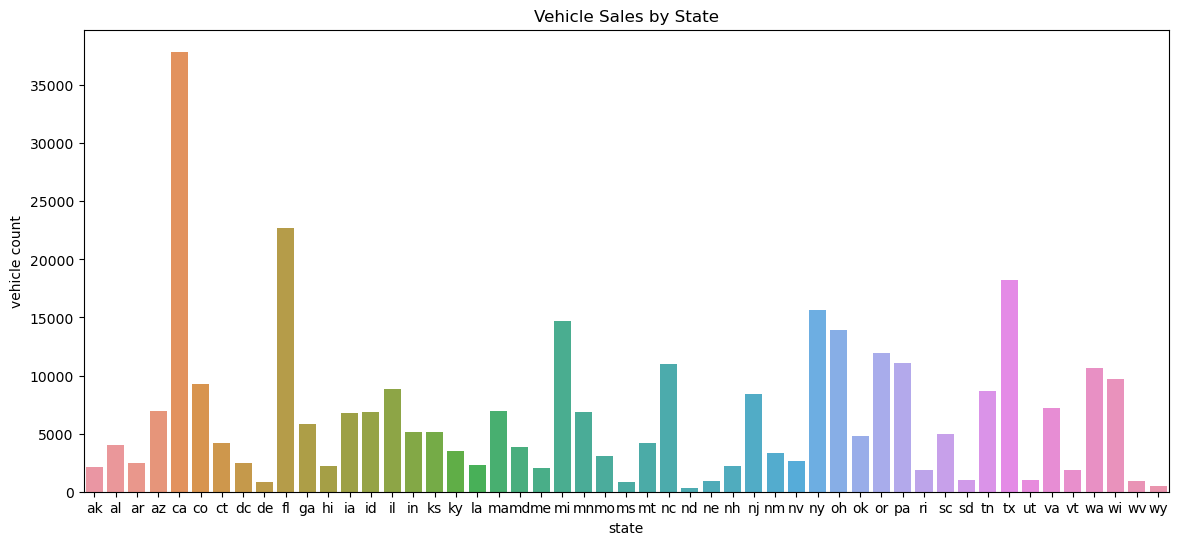

In [22]:
fig, ax = plt.subplots (figsize=(14, 6))
sns.barplot(grouped_by_state, x='state', y='vehicle count').set(title='Vehicle Sales by State')
plt.show()

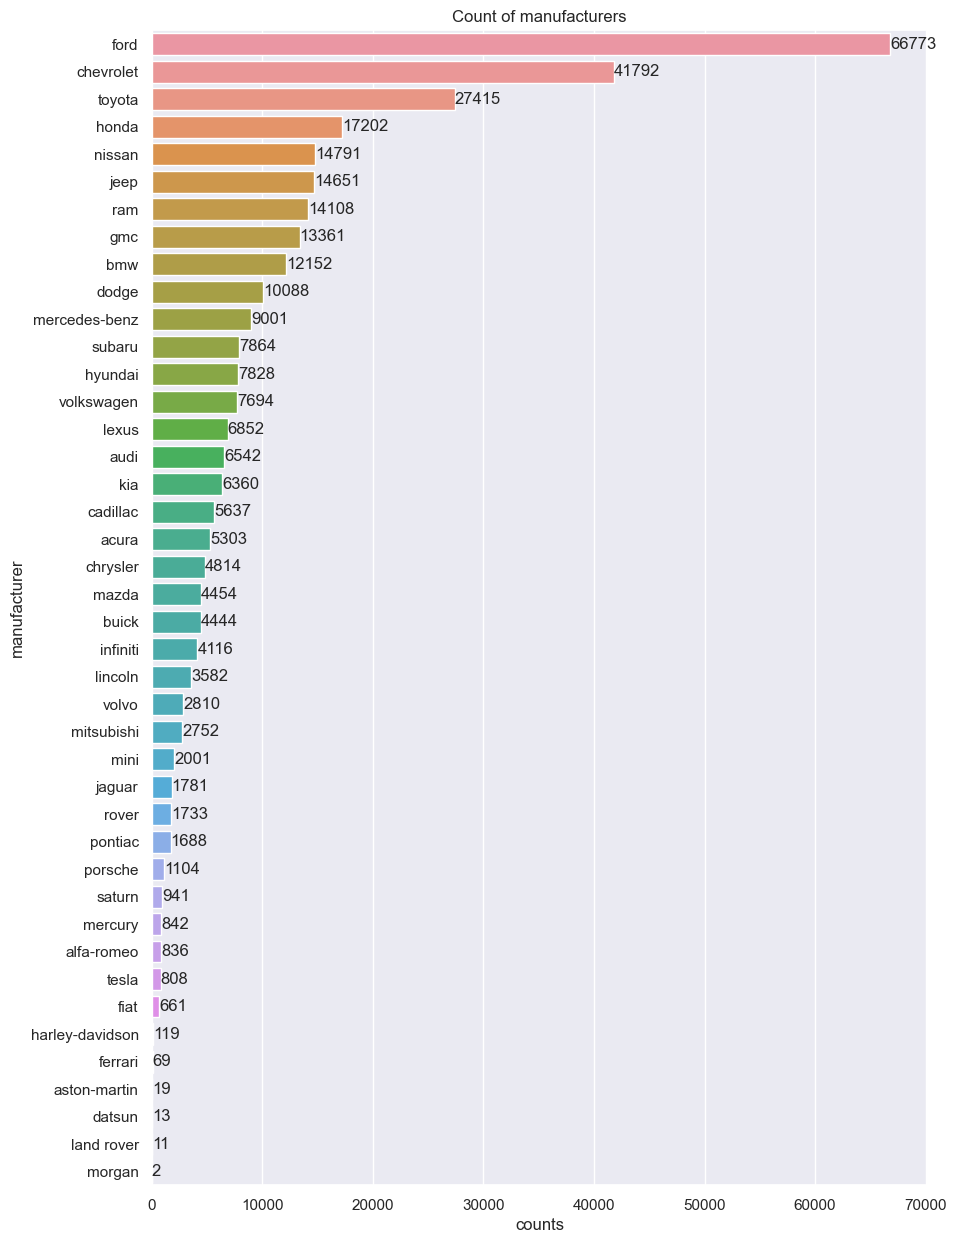

In [23]:
sns.set(rc={"figure.figsize":(10,15)})
ax = sns.barplot(data=cars_cleaning.groupby(by='manufacturer').size().reset_index(name="counts").sort_values('counts', ascending=False), 
              y='manufacturer', x='counts')
ax.set(title="Count of manufacturers") # title barplot

# label each bar in barplot
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    # adding text to each bar
    ax.text(x = width+5, # x-coordinate position of data label, padded 5 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = "{:.0f}".format(width), # data label, formatted to ignore decimals
    va = "center") # sets vertical alignment (va) to center

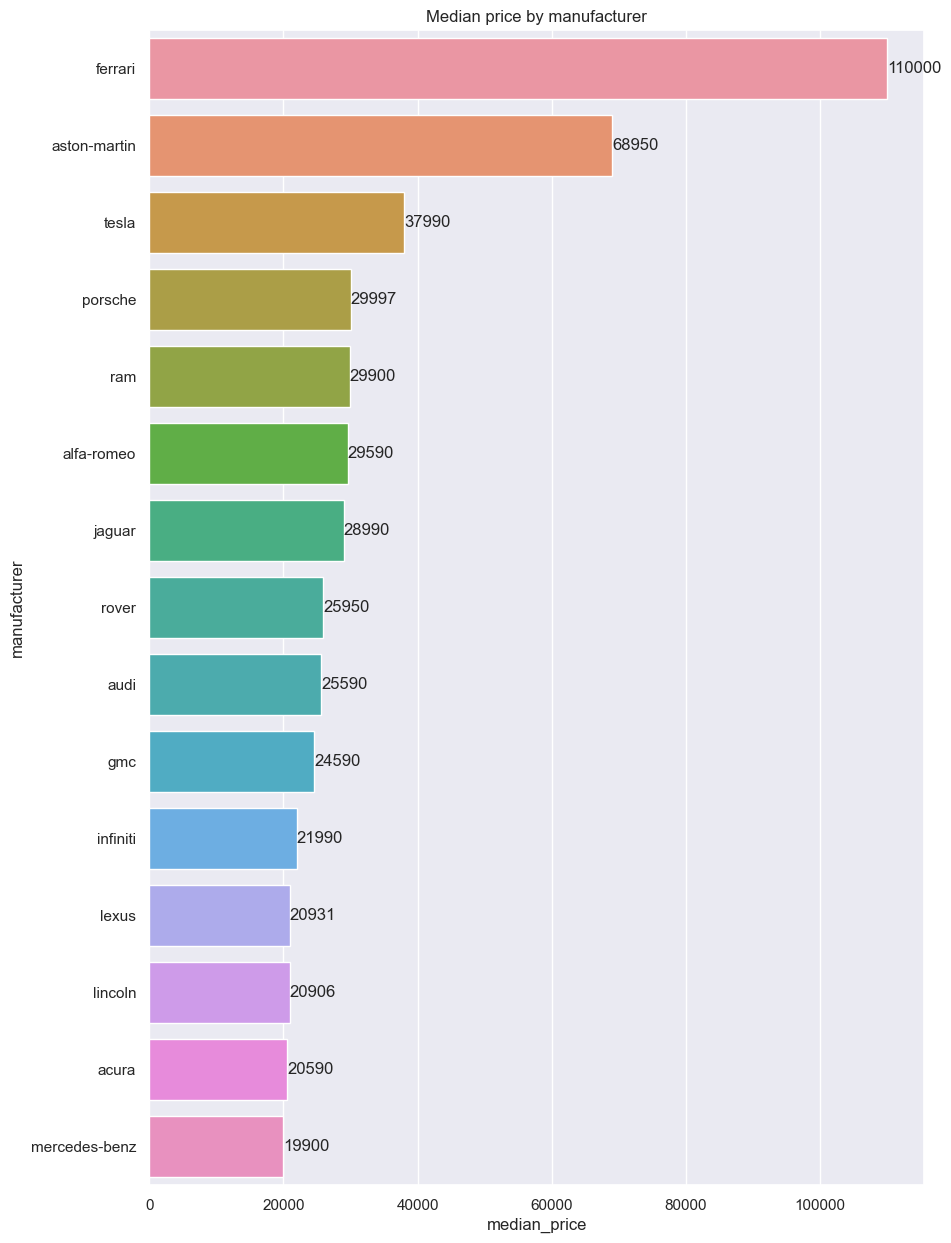

In [24]:
sns.set(rc={"figure.figsize":(10,15)})
ax = sns.barplot(data=cars_cleaning.groupby(by='manufacturer')['price'].median().reset_index(name="median_price").sort_values('median_price', ascending=False).head(15), 
              y='manufacturer', x='median_price')
ax.set(title="Median price by manufacturer") # title barplot

# label each bar in barplot
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    # adding text to each bar
    ax.text(x = width+5, # x-coordinate position of data label, padded 5 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = "{:.0f}".format(width), # data label, formatted to ignore decimals
    va = "center") # sets vertical alignment (va) to center

In [26]:
#create a new DF with only the up to date numeric values to look at correlations
dfcorr = cars_cleaning[['price', 'year', 'odometer']]
cols = dfcorr.columns

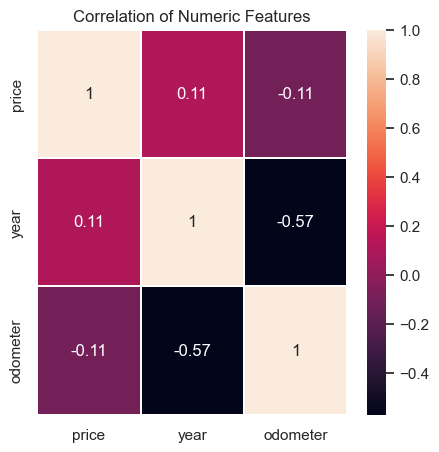

In [27]:
#let's look at correlations between features to decide on what we do with the rest
#highest_corr = cali.corr()[['median_house_value']].nlargest(columns = 'median_house_value', n = 2).index[1]
#print(highest_corr)
#HEATMAP TO VISUALIZE CORRELATION MATRIX 
fig, ax = plt.subplots (figsize=(5, 5))
sns.heatmap(dfcorr.corr(), annot = True, linewidths=.1).set(title='Correlation of Numeric Features')
plt.show()

In [281]:
# Define ANOVA test to see influence of categorical features against our numerical price target

def anova(cars_cleaning, feature):
    model_ols = ols('price ~ {}'.format(feature), data=cars).fit()
    anova_table = anova_lm(model_ols, typ=2)
    return anova_table

In [239]:
# Test for statistical importance of categoricals

anova_for_categoricals = []
for i in categoricals:
    anova_for_categoricals.append([i,anova(cars_cleaning, i).loc[i,'PR(>F)']])

anova_for_categoricals = pd.DataFrame(anova_for_categoricals, columns=['feature','anova pvalue'])
anova_for_categoricals.columns = [str(column) for column in anova_for_categoricals.columns]

#output values
anova_for_categoricals
#if P val <0.05 then the categorical has an influence on our target price so in this case only state

,feature,anova pvalue
0,manufacturer,0.897558
1,fuel,0.968907
2,title_status,0.996566
3,transmission,0.181622
4,type,0.515762
5,state,0.000884


### Final Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [28]:
#as we know title status and fuel have no input on price let's drop them
cars_cleaning = cars_cleaning.drop(['title_status', 'region', 'fuel'], axis=1)

In [29]:
duplicates = len(cars_cleaning)-len(cars_cleaning.drop_duplicates())
print(duplicates)

66548


In [30]:
#remove duplicates and reset index:
cars_cleaning = cars_cleaning.drop_duplicates()
cars_cleaning = cars_cleaning.reset_index(drop=True)

In [31]:
#one hot encode our categorical data (tried in pipeline but getting wierd error from a category value?)
cars_cleaning = pd.get_dummies(cars_cleaning)

In [546]:
#looking at the data above and in prec steps we should definately scale data and also OHE our categorical values
#this can be done on our modeling step with our pipeline

In [32]:
#put price on logarithmic scale to make more dense for better calculations
cars_cleaning['log_price_usd'] = np.log(cars_cleaning.price)
cars_cleaning = cars_cleaning.drop(columns=['price'])

In [33]:
#create new df for model so we don't mix up data when changes made
cars_clean = cars_cleaning

In [35]:
#crashing computer so going to sample a smaller set of data first:

cars_df_sample = cars_clean.sample(frac=0.1, random_state=32)

#split our training and test data 

X = cars_df_sample.drop('log_price_usd', axis = 1)
y = cars_df_sample['log_price_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18792 entries, 159914 to 7583
Columns: 26224 entries, year to state_wy
dtypes: bool(26221), int64(3)
memory usage: 470.5 MB


In [155]:
# getting columns of type object to do one hot encoding this would take all objects but we want to split so commented out
cat_cols = []
for c in X_train.columns:
    if X_train[c].dtype == 'object':
        cat_cols.append(c)
# getting columns of type category to do ordinal encoding...but we broke verything assigning this as a dtype
#ord_cols = []
#for c in X_train.columns:
#    if X_train[c].dtype == 'category':
#        ord_cols.append(c)        

cat_cols #= ['manufacturer', 'fuel', 'title_status', 'transmission', 'type', 'state']
#ord_cols = ['condition', 'size']
#ord_vals = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new'], ['sub-compact', 'compact', 'mid-size', 'full-size']]       

['manufacturer', 'fuel', 'title_status', 'transmission', 'type', 'state']

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [36]:
start_time = time.time()

params = {'scaler__with_mean':[False], 'ridge__alpha':[1e-3, 1e-2, 1, 5, 10]}


pipe = Pipeline([('scaler',StandardScaler()),
                 ('ridge', Ridge())
])                 
grid = GridSearchCV(estimator = pipe,
                       param_grid = params,
                       scoring = 'neg_mean_squared_error',
                       cv = 5)
grid.fit(X_train, y_train)

best_params = grid.best_params_
    
best_model = grid.best_estimator_
R2_Score_train = best_model.score(X_train, y_train)
    
pred_train_y = best_model.predict(X_train)
pred_test_y = best_model.predict(X_test)
    
train_mse = mean_squared_error(y_train, pred_train_y)
test_mse = mean_squared_error(y_test, pred_test_y)

end_time = time.time()
time_taken = end_time - start_time
    
    
print(f' Predict Car Price Model Calculations :')
print('__________________________________________________________________\n')
print(f'Training MSE is:                             {train_mse}')
print(f'Test MSE is:                                 {test_mse}')
print(f'Best Parameters are:                         {best_params}')
print(f'R2 model score is:                           {R2_Score_train}')
print(f'Calculation time was:                        {time_taken:.2f}\n')
print('END')

 Predict Car Price Model Calculations :
__________________________________________________________________

Training MSE is:                             0.5406298440304392
Test MSE is:                                 0.9241618155717093
Best Parameters are:                         {'ridge__alpha': 10, 'scaler__with_mean': False}
R2 model score is:                           0.614253104213467
Calculation time was:                        1077.88

END


## Positive effects on Price
Below we can see the top 20 positive coefficients making up the top 20 largest 'weights' on our target price.  Year is clearly the most important, a higher year will increase the value most. 

In [86]:
#let's extract the coefficients from our winning model (selected by gridsearch):
ridge_c = pd.DataFrame([best_model.named_steps['ridge'].coef_], columns = best_model.named_steps['scaler'].get_feature_names_out())
sorted_coefficients = ridge_c.sort_values(by=ridge_c.index[0], ascending=False, axis=1).transpose()
#here are the top 20 coeff's from our model
sorted_coefficients.head(20)

,0
year,0.216115
manufacturer_audi,0.180149
manufacturer_ford,0.148117
manufacturer_mercedes-benz,0.093722
manufacturer_jeep,0.090723
model_tundra,0.081564
model_tacoma,0.080974
manufacturer_dodge,0.078294
manufacturer_mini,0.074002
manufacturer_ram,0.071534


## Negative effects on Price
Below we can see the top 20 negative coefficients making up the top 20 largest negative 'weights' on our target price.  Nissan, age and odometer reading are clearly the most important, the age or odometer reading will decrease the price most. 

In [87]:
sorted_coefficients = ridge_c.sort_values(by=ridge_c.index[0], ascending=True, axis=1).transpose()
#here are the top 20 coeff's from our model
sorted_coefficients.head(20)

,0
manufacturer_nissan,-0.251162
age,-0.238853
odometer,-0.215944
manufacturer_toyota,-0.171443
manufacturer_hyundai,-0.152665
state_or,-0.106393
manufacturer_subaru,-0.102169
manufacturer_kia,-0.101351
model_focus,-0.080324
model_Mustang,-0.079512


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Model Accuracy

Our R2 score of our ridge model with an alpha of 10 was 0.614 meaning 61.4% of the variance in the target variable (price) can be explained by the model's inputs. While this is no bad and indicates decent level of prediction, there's still a significant portion of variance unexplained by the model.  Our test MSE and training MSE's are also different enough to imply we do not have overfitting.  The model could probably be improved further with feature engineering, especially of the models as the data was messy.  

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

# Used Car Price Prediction Analysis & Inventory Tuning Recomendations
### Executive Summary

This report is the result of a comprehensive analysis to understand the key features influencing used car prices. Utilizing advanced data science, including, data cleaning, feature engineering, Multiple Linear Regression models, our goal was to identify attributes that significantly impact the value of used cars. This information is intended to assist dealers to optimize their inventory selection to maximize profitability.
Data Overview

The analysis was conducted with a dataset of almost 500k vehicles accross the United States and included common attributes of used cars, such as year, make, model, mileage, fuel type, transmission type and more. Prior to modeling, the data underwent cleaning to remove or impute missing values, understand the relationships with the target variable price and included normalization of numeric features to compensate for skewed data.  We also had a lot of non numeric values and performed one-hot encoding of these categorical variables creating almost 26k columns of data.

### Findings

1. Influential Factors on Car Prices

    Year of Manufacture: Is the most significant positive predictor of its price. Newer models tend to fetch higher prices.
    Mileage: Reading impacts the price negatively the most. Hence high mileage correlates with lower prices.
    There are also details on specific models you may want or prefer avoid.  These brands and models can be seen to have a large impact with very positive or negative effects on price.

2. Model Used and Performance

    Ridge Regression: Provided decent accuracy in our predictions with an R² of 0.61 or predicting 61% of the variance in price from our features. 
    

3. Recommendations for Inventory Management

    Newer Models bring in the most: Given the strong influence of the car's year, stocking newer models could be more profitable assuming margins are percentage based.  Also shopping for vehicles out of state for example in Oregon could also allow purchasing at a cheaper price (almost 10% for some models) then a higher resale value elsewhere.  
    Diverse Brands and Mileage: While lower mileage cars are valued higher, there is a market for higher mileage cars, suggesting a diverse range in odometer readings may appeal to a broader customer base.
    Special Attention to specific brands and models: The preference for Fords and  should be considered when selecting inventory.

### Conclusion

This type of data driven analysis at first might not seem usefull to a seasoned professional as the obvious indicators such as mileage, age and luxury models are known price drivers, however beyond it's basics it can be great for further insight into hidden market data such as leveraging out of state sales for specific models and more.  This data driven analysis also provides powerfull insights in what to avoid to remain profitable.  Data driven decision making will help dealerships reduce pricing risks by leverage better approaches to a more profitable inventory management in an ever changing market.  
